### Import libraries

In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

### Load data

In [22]:
data_dir = "../../database/microeconomic_data/hkex_ticks_day/"

In [23]:
def stocks_data(symbols, dates):

  df = pd.DataFrame(index=dates)

  for symbol in symbols:

    new_df = pd.read_csv(data_dir+ "hkex_" + symbol  +".csv", index_col='Date', parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
    new_df = new_df.rename(columns={'Close': symbol})
    
    #df = pd.merge(df,new_df, how='outer', on=['Date'])
    df = df.join(new_df)

  return df

,0001,0005,0388
2015-01-02,74.471855,54.244644,150.375885
2015-01-05,73.736710,53.438297,154.113556
2015-01-06,71.814140,52.595306,154.374344
2015-01-07,71.192131,52.045536,155.852036
2015-01-08,71.022484,52.192142,154.548187


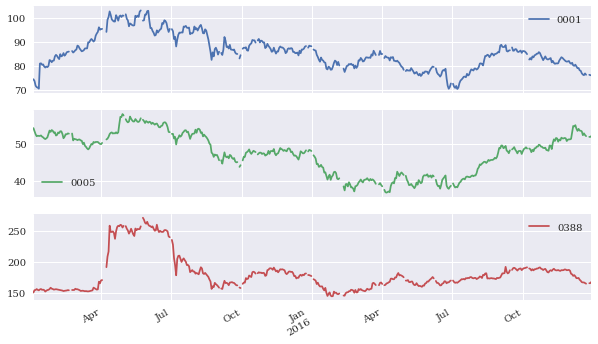

In [24]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ["0001", "0005", "0388"]

df = stocks_data(symbols, dates)

df.fillna(method='pad')
df.plot(figsize=(10, 6), subplots=True);
df.head()

                Close
2017-01-03  78.666588
2017-01-04  78.103447
2017-01-05  78.579956
2017-01-06  78.103447
2017-01-09  77.973503
...               ...
2020-09-24  46.349998
2020-09-25  46.549999
2020-09-28  46.549999
2020-09-29  46.500000
2020-09-30  46.599998

[978 rows x 1 columns]


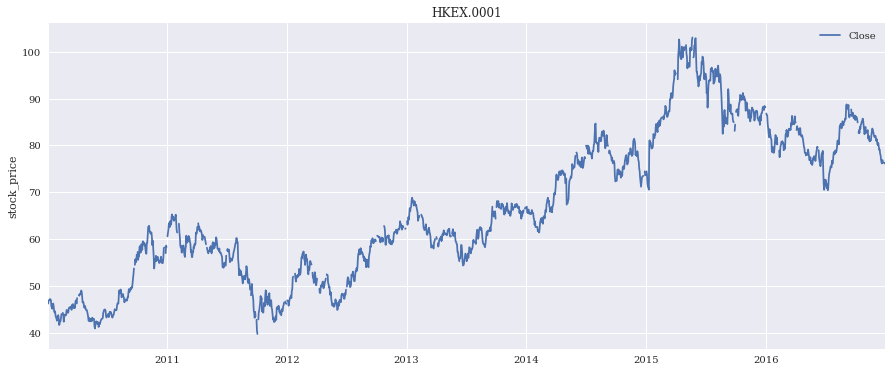

In [25]:
dates = pd.date_range('2010-01-02','2016-12-31',freq='B')
test_dates=pd.date_range('2017-01-03','2020-09-30',freq='B')
symbols = ["0001"]

df_0001 = stocks_data(symbols, dates)
df_0001_test=stocks_data(symbols, test_dates)

df_0001 = df_0001.rename(columns={'0001': 'Close'})
df_0001_test=df_0001_test.rename(columns={'0001': 'Close'})
print(df_0001_test)


df_0001.plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("HKEX.0001")
plt.show()

In [26]:
df_0001 = df_0001.fillna(method='ffill')
df_0001_test= df_0001_test.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_0001['Close'] = scaler.fit_transform(df_0001['Close'].values.reshape(-1,1))
df_0001_test['Close'] = scaler.fit_transform(df_0001_test['Close'].values.reshape(-1,1))
print(df_0001_test)
print(df_0001)

               Close
2017-01-03  0.342003
2017-01-04  0.320400
2017-01-05  0.338680
2017-01-06  0.320400
2017-01-09  0.315416
...              ...
2020-09-24 -0.897675
2020-09-25 -0.890003
2020-09-28 -0.890003
2020-09-29 -0.891921
2020-09-30 -0.888085

[978 rows x 1 columns]
               Close
2010-01-04 -0.794644
2010-01-05 -0.774156
2010-01-06 -0.772692
2010-01-07 -0.768302
2010-01-08 -0.763912
...              ...
2016-12-26  0.155607
2016-12-27  0.155607
2016-12-28  0.155607
2016-12-29  0.150127
2016-12-30  0.150127

[1825 rows x 1 columns]


In [53]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    print(data_raw.shape)
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_0001, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

(1825, 1)
x_train.shape =  (1412, 59, 1)
y_train.shape =  (1412, 1)
x_test.shape =  (353, 59, 1)
y_test.shape =  (353, 1)


In [28]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [29]:
y_train.size(),x_train.size()

(torch.Size([1412, 1]), torch.Size([1412, 59, 1]))

In [30]:
n_steps = look_back-1
batch_size = 32
num_epochs = 100 #n_iters / (len(train_X) / batch_size)

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### **Build model**

In [31]:
# Hyperparameters
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# check dimensions
print(model)

print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### Train model

In [32]:
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.015969986096024513
Epoch  20 MSE:  0.008717499673366547
Epoch  30 MSE:  0.0038063013926148415
Epoch  40 MSE:  0.002468259772285819
Epoch  50 MSE:  0.0023678678553551435
Epoch  60 MSE:  0.002093113260343671
Epoch  70 MSE:  0.0019932305440306664
Epoch  80 MSE:  0.0019257926614955068
Epoch  90 MSE:  0.0018688492709770799


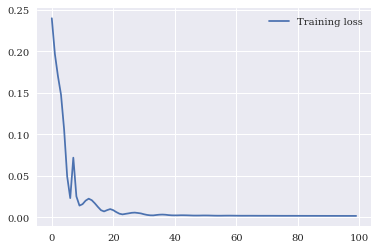

In [33]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [34]:
np.shape(y_train_pred)

torch.Size([1412, 1])

In [35]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.11 RMSE
Test Score: 1.13 RMSE


(353, 1)


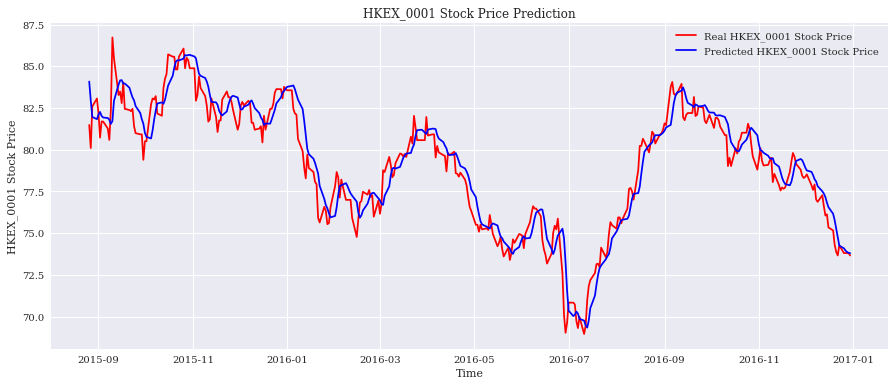

In [36]:
# Visualising the results
def visualization(df,y_test,y_test_pred):
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    print(y_test.shape)

    axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real HKEX_0001 Stock Price')
    axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted HKEX_0001 Stock Price')
    #axes.xticks(np.arange(0,394,50))
    plt.title('HKEX_0001 Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('HKEX_0001 Stock Price')
    plt.legend()
    #plt.savefig('HKEX_0001_pred.png')
    plt.show()

visualization(df_0001,y_test,y_test_pred)

In [37]:
#### References


- Predicting Stock Price using LSTM, *Taron Zakaryan* - https://www.kaggle.com/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch

               Close
2017-01-03  0.342003
2017-01-04  0.320400
2017-01-05  0.338680
2017-01-06  0.320400
2017-01-09  0.315416
...              ...
2020-09-24 -0.897675
2020-09-25 -0.890003
2020-09-28 -0.890003
2020-09-29 -0.891921
2020-09-30 -0.888085

[978 rows x 1 columns]
(978, 1)
<class 'numpy.ndarray'>
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

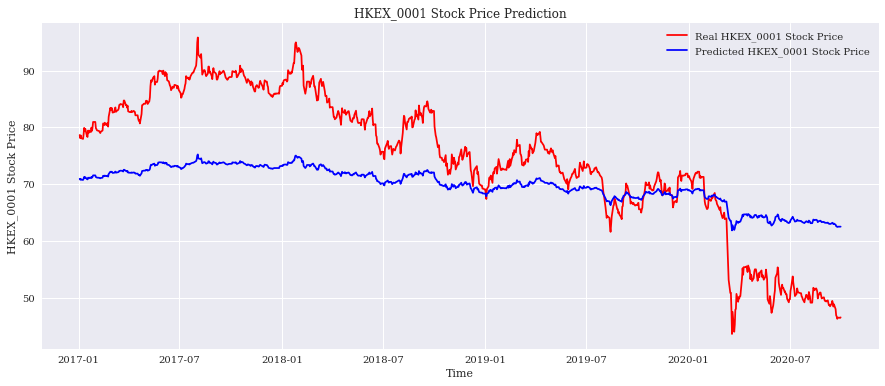

In [51]:
# function to create train, test data given stock data and sequence length
from numpy import zeros, newaxis

def predict_data(stock):
    print(stock)

    actual_output = stock.values 
    
    actual_output = torch.from_numpy(actual_output).type(torch.Tensor)
    train_input=actual_output[:,:,newaxis]
    train_input=np.array(train_input)
    train_input= torch.from_numpy(train_input).type(torch.Tensor)

    # make prediction of the input 
    pred=model(train_input)

    # invert predictions
    pred = scaler.inverse_transform(pred.detach().numpy())
    actual_output = scaler.inverse_transform(actual_output.detach().numpy())
    print(pred.shape)
    return pred,actual_output

def generate_signal (pred,actual_output):
    signal=[]
    for p,a in zip(pred,actual_output):

        # shows that current price is overvalued, sell the stock
        if(p>a):
            signal.append(-1)
        # shows that current price is undervalued, buy the stock
        elif(p<a):
            signal.append(1)

        elif(p==a):
            signal.append(0)
    return signal


pred,acutal_output=predict_data(df_0001_test)
signal=generate_signal(pred,acutal_output)
print(signal)
visualization(df_0001_test,acutal_output,pred)


